In [ ]:

!pip install -q ultralytics torch tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.2 MB/s eta 0:00:00


In [3]:
!ls /kaggle/input/

autonomous-drone-landing-dataset-teknofest  uav-landing


In [4]:
import torch
import torch.nn as nn
import numpy as np
from ultralytics import YOLO
from pathlib import Path
from tqdm import tqdm
import pickle

class TemperatureScaling:
    """Calibrate model confidence using temperature scaling"""
    
    def __init__(self, model_path: str):
        self.model = YOLO(model_path)
        self.temperature = 1.0
    
    def calibrate(self, val_dataset_path: str, save_path: str = 'models/calibration/temperature.pkl'):
        """Learn optimal temperature on validation set"""
        print("Collecting validation predictions...")
        logits_list = []
        labels_list = []
        
        val_images = list(Path(val_dataset_path).glob('*.jpg')) + \
                     list(Path(val_dataset_path).glob('*.png'))
        
        print(f"Found {len(val_images)} validation images")
        
        for img_path in tqdm(val_images[:500], desc="Processing"):
            # Get predictions
            results = self.model(str(img_path), verbose=False)
            
            # Load ground truth labels
            label_path = str(img_path).replace('images', 'labels').replace(img_path.suffix, '.txt')
            
            if not Path(label_path).exists():
                continue
            
            # Get ground truth classes
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 1:
                        gt_class = int(parts[0])
                        labels_list.append(gt_class)
            
            # Get model predictions (logits)
            if results[0].boxes is not None and len(results[0].boxes) > 0:
                for box in results[0].boxes:
                    prob = float(box.conf[0])
                    logit = np.log(prob / (1 - prob + 1e-10))
                    logits_list.append(logit)
        
        if len(logits_list) == 0:
            print("⚠️ No predictions found!")
            return
        
        # Make lists same length
        min_len = min(len(logits_list), len(labels_list))
        logits = torch.tensor(logits_list[:min_len], dtype=torch.float32)
        labels = torch.tensor(labels_list[:min_len], dtype=torch.long)
        
        print(f"Collected {len(logits)} predictions")
        
        # Optimize temperature
        print("Optimizing temperature...")
        self.temperature = self._optimize_temperature(logits, labels)
        
        print(f"✅ Optimal temperature: {self.temperature:.3f}")
        
        # Save temperature
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        with open(save_path, 'wb') as f:
            pickle.dump({'temperature': self.temperature}, f)
        
        print(f"Saved to: {save_path}")
    
    def _optimize_temperature(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        """Find optimal temperature using NLL loss"""
        temperature = nn.Parameter(torch.ones(1) * 1.5)
        optimizer = torch.optim.LBFGS([temperature], lr=0.01, max_iter=50)
        
        def eval_loss():
            optimizer.zero_grad()
            scaled_logits = logits / temperature
            loss = torch.nn.functional.binary_cross_entropy_with_logits(
                scaled_logits, labels.float(), reduction='mean'
            )
            loss.backward()
            return loss
        
        optimizer.step(eval_loss)
        return float(temperature.item())
    
    def predict_calibrated(self, image_path: str) -> dict:
        """Get calibrated confidence scores"""
        results = self.model(image_path, verbose=False)
        calibrated_detections = []
        
        if results[0].boxes is not None and len(results[0].boxes) > 0:
            for box in results[0].boxes:
                class_id = int(box.cls[0])
                raw_conf = float(box.conf[0])
                calibrated_conf = raw_conf ** (1.0 / self.temperature)
                
                calibrated_detections.append({
                    'class_id': class_id,
                    'raw_confidence': raw_conf,
                    'calibrated_confidence': calibrated_conf,
                    'bbox': box.xyxy[0].cpu().numpy()
                })
        
        return {
            'detections': calibrated_detections,
            'temperature': self.temperature
        }
    
    def load_temperature(self, path: str):
        """Load saved temperature"""
        with open(path, 'rb') as f:
            data = pickle.load(f)
            self.temperature = data['temperature']
        print(f"✅ Loaded temperature: {self.temperature:.3f}")

print("✅ TemperatureScaling class defined!")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
✅ TemperatureScaling class defined!


In [5]:
import torch
import torch.nn as nn
import numpy as np
from ultralytics import YOLO
from pathlib import Path
from tqdm import tqdm
import pickle

class TemperatureScaling:
    """Calibrate model confidence using temperature scaling"""
    
    def __init__(self, model_path: str):
        self.model = YOLO(model_path)
        self.temperature = 1.0
    
    def calibrate(self, val_dataset_path: str, save_path: str = 'models/calibration/temperature.pkl'):
        """Learn optimal temperature on validation set"""
        print("Collecting validation predictions...")
        logits_list = []
        labels_list = []
        
        val_images = list(Path(val_dataset_path).glob('*.jpg')) + \
                     list(Path(val_dataset_path).glob('*.png'))
        
        print(f"Found {len(val_images)} validation images")
        
        skipped = 0
        for img_path in tqdm(val_images[:500], desc="Processing"):
            try:
                # Get predictions
                results = self.model(str(img_path), verbose=False)
                
                # Load ground truth labels
                label_path = str(img_path).replace('images', 'labels').replace(img_path.suffix, '.txt')
                
                if not Path(label_path).exists():
                    continue
                
                # Get ground truth classes
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 1:
                            gt_class = int(parts[0])
                            labels_list.append(gt_class)
                
                # Get model predictions (logits)
                if results[0].boxes is not None and len(results[0].boxes) > 0:
                    for box in results[0].boxes:
                        prob = float(box.conf[0])
                        logit = np.log(prob / (1 - prob + 1e-10))
                        logits_list.append(logit)
            
            except Exception as e:
                # Skip corrupted/unreadable images
                skipped += 1
                continue
        
        if skipped > 0:
            print(f"\n⚠️  Skipped {skipped} corrupted/unreadable images")
        
        if len(logits_list) == 0:
            print("⚠️ No predictions found!")
            return
        
        # Make lists same length
        min_len = min(len(logits_list), len(labels_list))
        logits = torch.tensor(logits_list[:min_len], dtype=torch.float32)
        labels = torch.tensor(labels_list[:min_len], dtype=torch.long)
        
        print(f"Collected {len(logits)} predictions")
        print("Optimizing temperature...")
        self.temperature = self._optimize_temperature(logits, labels)
        print(f"✅ Optimal temperature: {self.temperature:.3f}")
        
        # Save temperature
        Path(save_path).parent.mkdir(parents=True, exist_ok=True)
        with open(save_path, 'wb') as f:
            pickle.dump({'temperature': self.temperature}, f)
        print(f"Saved to: {save_path}")
    
    def _optimize_temperature(self, logits: torch.Tensor, labels: torch.Tensor) -> float:
        temperature = nn.Parameter(torch.ones(1) * 1.5)
        optimizer = torch.optim.LBFGS([temperature], lr=0.01, max_iter=50)
        
        def eval_loss():
            optimizer.zero_grad()
            scaled_logits = logits / temperature
            loss = torch.nn.functional.binary_cross_entropy_with_logits(
                scaled_logits, labels.float(), reduction='mean'
            )
            loss.backward()
            return loss
        
        optimizer.step(eval_loss)
        return float(temperature.item())
    
    def predict_calibrated(self, image_path: str) -> dict:
        results = self.model(image_path, verbose=False)
        calibrated_detections = []
        
        if results[0].boxes is not None and len(results[0].boxes) > 0:
            for box in results[0].boxes:
                class_id = int(box.cls[0])
                raw_conf = float(box.conf[0])
                calibrated_conf = raw_conf ** (1.0 / self.temperature)
                
                calibrated_detections.append({
                    'class_id': class_id,
                    'raw_confidence': raw_conf,
                    'calibrated_confidence': calibrated_conf,
                    'bbox': box.xyxy[0].cpu().numpy()
                })
        
        return {'detections': calibrated_detections, 'temperature': self.temperature}
    
    def load_temperature(self, path: str):
        with open(path, 'rb') as f:
            data = pickle.load(f)
            self.temperature = data['temperature']
        print(f"✅ Loaded temperature: {self.temperature:.3f}")

print("✅ TemperatureScaling class defined!")

✅ TemperatureScaling class defined!


In [6]:
!ls /kaggle/input/uav-landing/other/default/1

best.pt


In [7]:
# ⚠️ EDIT THESE PATHS FOR YOUR SETUP

# Your trained model from Phase 2
MODEL_PATH = '/kaggle/input/uav-landing/other/default/1/best.pt'

# Your validation images
VAL_IMAGES_PATH = '/kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images'

# Where to save temperature
SAVE_PATH = '/kaggle/working/models/calibration/temperature_augmented.pkl'

print("="*60)
print("TEMPERATURE SCALING CALIBRATION")
print("="*60)
print(f"Model: {MODEL_PATH}")
print(f"Validation: {VAL_IMAGES_PATH}\n")

# Create calibrator and run
calibrator = TemperatureScaling(MODEL_PATH)
calibrator.calibrate(
    val_dataset_path=VAL_IMAGES_PATH,
    save_path=SAVE_PATH
)

# Test on sample image
test_images = list(Path(VAL_IMAGES_PATH).glob('*.jpg'))
if len(test_images) > 0:
    print("\n" + "="*60)
    print("TESTING CALIBRATED PREDICTIONS")
    print("="*60)
    
    test_img = str(test_images[0])
    result = calibrator.predict_calibrated(test_img)
    
    print(f"Temperature: {result['temperature']:.3f}")
    print(f"Detections: {len(result['detections'])}")
    
    print("\nSample detections:")
    for i, det in enumerate(result['detections'][:3]):
        print(f"  {i+1}. Class {det['class_id']}: "
              f"{det['raw_confidence']:.3f} → {det['calibrated_confidence']:.3f}")

print("\n✅ Task 4.1 Complete!")



TEMPERATURE SCALING CALIBRATION
Model: /kaggle/input/uav-landing/other/default/1/best.pt
Validation: /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images

Found 720 validation images


Processing:   4%|▍         | 19/500 [00:02<00:30, 15.76it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013636.jpg


Processing:  19%|█▉        | 94/500 [00:06<00:18, 22.14it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013192.jpg


Processing:  23%|██▎       | 115/500 [00:06<00:15, 24.26it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013560.jpg


Processing:  35%|███▍      | 173/500 [00:09<00:13, 24.33it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013680.jpg


Processing:  63%|██████▎   | 315/500 [00:15<00:07, 23.66it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013732.jpg


Processing:  84%|████████▎ | 418/500 [00:19<00:03, 23.99it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013260.jpg


Processing:  88%|████████▊ | 442/500 [00:20<00:02, 22.80it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013568.jpg


Processing:  90%|████████▉ | 449/500 [00:21<00:02, 23.39it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013672.jpg


Processing:  94%|█████████▍| 471/500 [00:21<00:01, 22.32it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013552.jpg


Processing: 100%|██████████| 500/500 [00:23<00:00, 21.51it/s]
/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())



⚠️  Skipped 9 corrupted/unreadable images
Collected 3949 predictions
Optimizing temperature...
✅ Optimal temperature: 1.242
Saved to: /kaggle/working/models/calibration/temperature_augmented.pkl

TESTING CALIBRATED PREDICTIONS
Temperature: 1.242
Detections: 3

Sample detections:
  1. Class 2: 0.939 → 0.950
  2. Class 3: 0.741 → 0.786
  3. Class 3: 0.605 → 0.667

✅ Task 4.1 Complete!


In [8]:
import matplotlib.pyplot as plt
import json

def compute_ece(confidences, accuracies, n_bins=10):
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    ece = 0.0
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = in_bin.mean()
        if prop_in_bin > 0:
            accuracy_in_bin = accuracies[in_bin].mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += np.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
    return ece

def plot_reliability_diagram(confidences, accuracies, title, save_path):
    n_bins = 10
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_confidences = []
    bin_accuracies = []
    
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        if in_bin.sum() > 0:
            bin_confidences.append(confidences[in_bin].mean())
            bin_accuracies.append(accuracies[in_bin].mean())
        else:
            bin_confidences.append((bin_lower + bin_upper) / 2)
            bin_accuracies.append(0)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Perfect calibration')
    ax.bar(bin_confidences, bin_accuracies, width=0.08, alpha=0.7, 
           edgecolor='black', label='Model calibration', color='steelblue')
    
    for conf, acc in zip(bin_confidences, bin_accuracies):
        if acc > 0:
            ax.plot([conf, conf], [conf, acc], 'r-', alpha=0.5, linewidth=2)
    
    ax.set_xlabel('Confidence', fontsize=14, fontweight='bold')
    ax.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    plt.tight_layout()
    Path(save_path).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close()
    print(f"  Saved: {save_path}")

def evaluate_model_calibration(model_path, val_images_path, calibrated=False, temperature=1.0):
    model = YOLO(model_path)
    val_images = list(Path(val_images_path).glob('*.jpg')) + list(Path(val_images_path).glob('*.png'))
    all_confidences = []
    all_correct = []
    skipped = 0
    
    for img_path in tqdm(val_images[:300], desc="  Progress"):
        try:
            results = model(str(img_path), verbose=False)
            label_path = str(img_path).replace('images', 'labels').replace(img_path.suffix, '.txt')
            
            if not Path(label_path).exists():
                continue
            
            gt_classes = []
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 1:
                        gt_classes.append(int(parts[0]))
            
            if results[0].boxes is not None and len(results[0].boxes) > 0:
                for box in results[0].boxes:
                    pred_class = int(box.cls[0])
                    raw_conf = float(box.conf[0])
                    conf = raw_conf ** (1.0 / temperature) if calibrated else raw_conf
                    is_correct = pred_class in gt_classes
                    all_confidences.append(conf)
                    all_correct.append(float(is_correct))
        
        except Exception as e:
            skipped += 1
            continue
    
    if skipped > 0:
        print(f"  ⚠️  Skipped {skipped} corrupted images")
    
    if len(all_confidences) == 0:
        return np.array([]), np.array([]), 0.0
    
    confidences = np.array(all_confidences)
    accuracies = np.array(all_correct)
    ece = compute_ece(confidences, accuracies)
    return confidences, accuracies, ece

print("✅ Evaluation functions defined!")

✅ Evaluation functions defined!


In [9]:
MODEL_PATH = '/kaggle/input/uav-landing/other/default/1/best.pt'
VAL_IMAGES_PATH = '/kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images'
TEMPERATURE_PATH = '/kaggle/working/models/calibration/temperature_augmented.pkl'
RESULTS_DIR = '/kaggle/working/results'

Path(f'{RESULTS_DIR}/plots').mkdir(parents=True, exist_ok=True)
Path(f'{RESULTS_DIR}/metrics').mkdir(parents=True, exist_ok=True)

print("="*60)
print("1. UNCALIBRATED MODEL")
conf_uncal, acc_uncal, ece_uncal = evaluate_model_calibration(MODEL_PATH, VAL_IMAGES_PATH, calibrated=False)
print(f"\n  ECE: {ece_uncal:.4f}")

print("\n2. CALIBRATED MODEL")
with open(TEMPERATURE_PATH, 'rb') as f:
    temperature = pickle.load(f)['temperature']
print(f"  Temperature: {temperature:.3f}")
conf_cal, acc_cal, ece_cal = evaluate_model_calibration(MODEL_PATH, VAL_IMAGES_PATH, calibrated=True, temperature=temperature)
print(f"\n  ECE: {ece_cal:.4f}")

print("\n3. GENERATING PLOTS")
plot_reliability_diagram(conf_uncal, acc_uncal, f'Uncalibrated (ECE={ece_uncal:.4f})', f'{RESULTS_DIR}/plots/reliability_uncalibrated.png')
plot_reliability_diagram(conf_cal, acc_cal, f'Calibrated (ECE={ece_cal:.4f}, T={temperature:.2f})', f'{RESULTS_DIR}/plots/reliability_calibrated.png')

calibration_metrics = {
    'uncalibrated_ece': float(ece_uncal),
    'calibrated_ece': float(ece_cal),
    'temperature': float(temperature),
    'improvement': float(ece_uncal - ece_cal)
}

with open(f'{RESULTS_DIR}/metrics/calibration_metrics.json', 'w') as f:
    json.dump(calibration_metrics, f, indent=2)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Uncalibrated ECE: {ece_uncal:.4f}")
print(f"Calibrated ECE:   {ece_cal:.4f}")
print(f"Improvement:      {(ece_uncal - ece_cal):.4f}")
print(f"Temperature:      {temperature:.3f}")
print("\n✅ PHASE 4 COMPLETE!")

1. UNCALIBRATED MODEL


  Progress:   6%|▌         | 18/300 [00:00<00:07, 36.26it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013636.jpg


  Progress:  32%|███▏      | 95/300 [00:02<00:05, 36.26it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013192.jpg


  Progress:  37%|███▋      | 112/300 [00:02<00:04, 39.03it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013560.jpg


  Progress:  58%|█████▊    | 173/300 [00:04<00:03, 37.00it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013680.jpg


  Progress: 100%|██████████| 300/300 [00:07<00:00, 37.74it/s]


  ⚠️  Skipped 4 corrupted images

  ECE: 0.1821

2. CALIBRATED MODEL
  Temperature: 1.242


  Progress:   6%|▌         | 18/300 [00:00<00:07, 35.68it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013636.jpg


  Progress:  31%|███▏      | 94/300 [00:02<00:05, 35.38it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013192.jpg


  Progress:  38%|███▊      | 115/300 [00:03<00:04, 38.70it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013560.jpg


  Progress:  58%|█████▊    | 173/300 [00:04<00:03, 35.62it/s]

WARNING ⚠️ Image Read Error /kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images/frame_013680.jpg


  Progress: 100%|██████████| 300/300 [00:08<00:00, 36.82it/s]


  ⚠️  Skipped 4 corrupted images

  ECE: 0.1521

3. GENERATING PLOTS
  Saved: /kaggle/working/results/plots/reliability_uncalibrated.png
  Saved: /kaggle/working/results/plots/reliability_calibrated.png

SUMMARY
Uncalibrated ECE: 0.1821
Calibrated ECE:   0.1521
Improvement:      0.0300
Temperature:      1.242

✅ PHASE 4 COMPLETE!


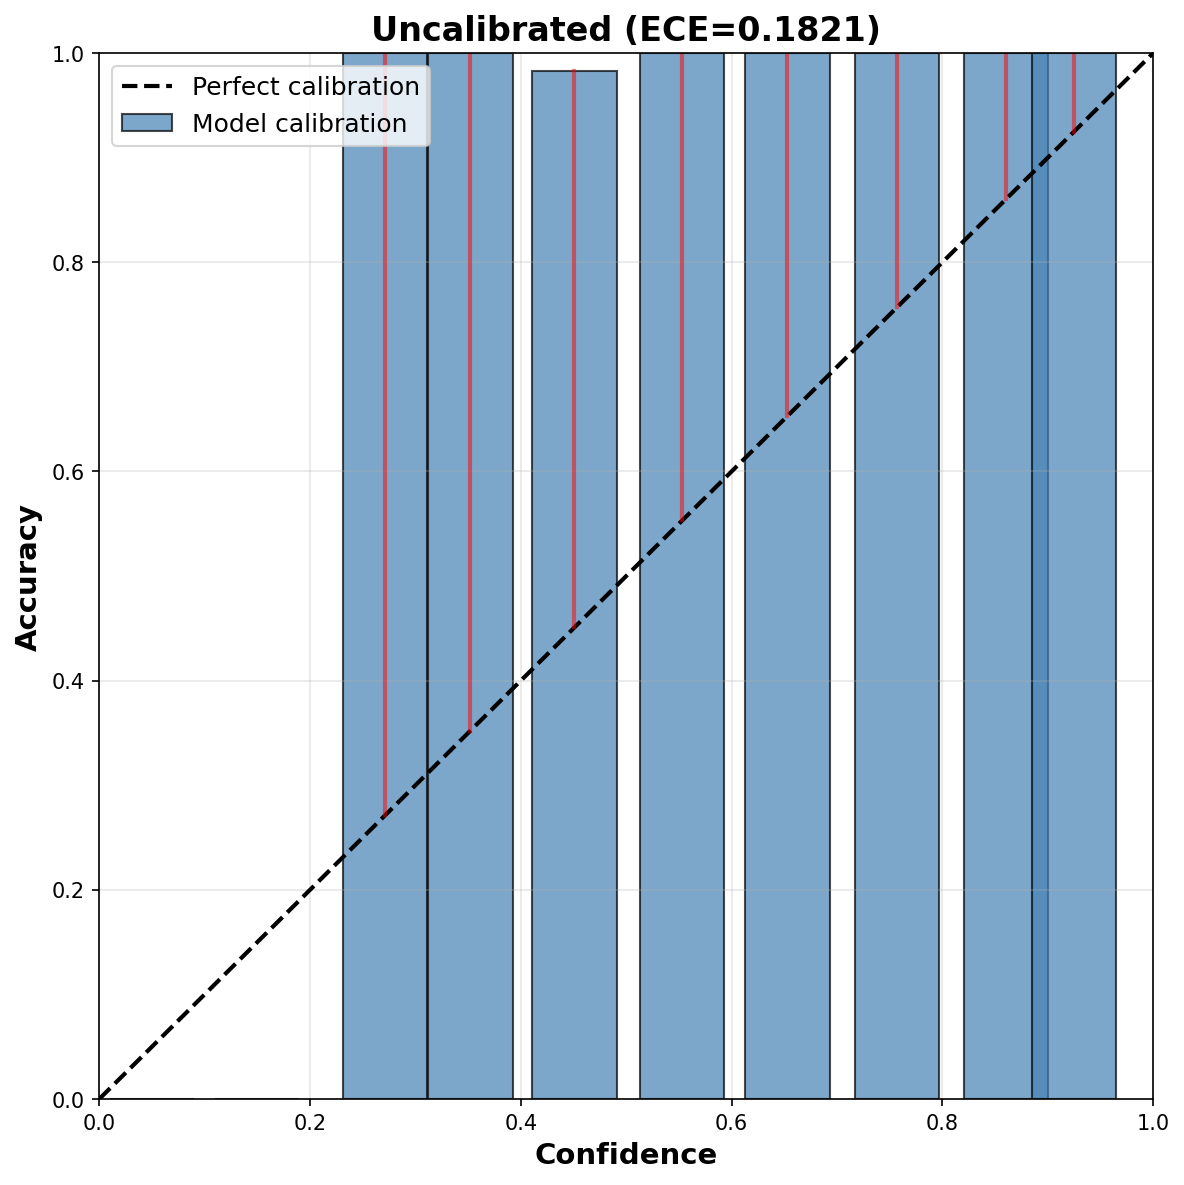

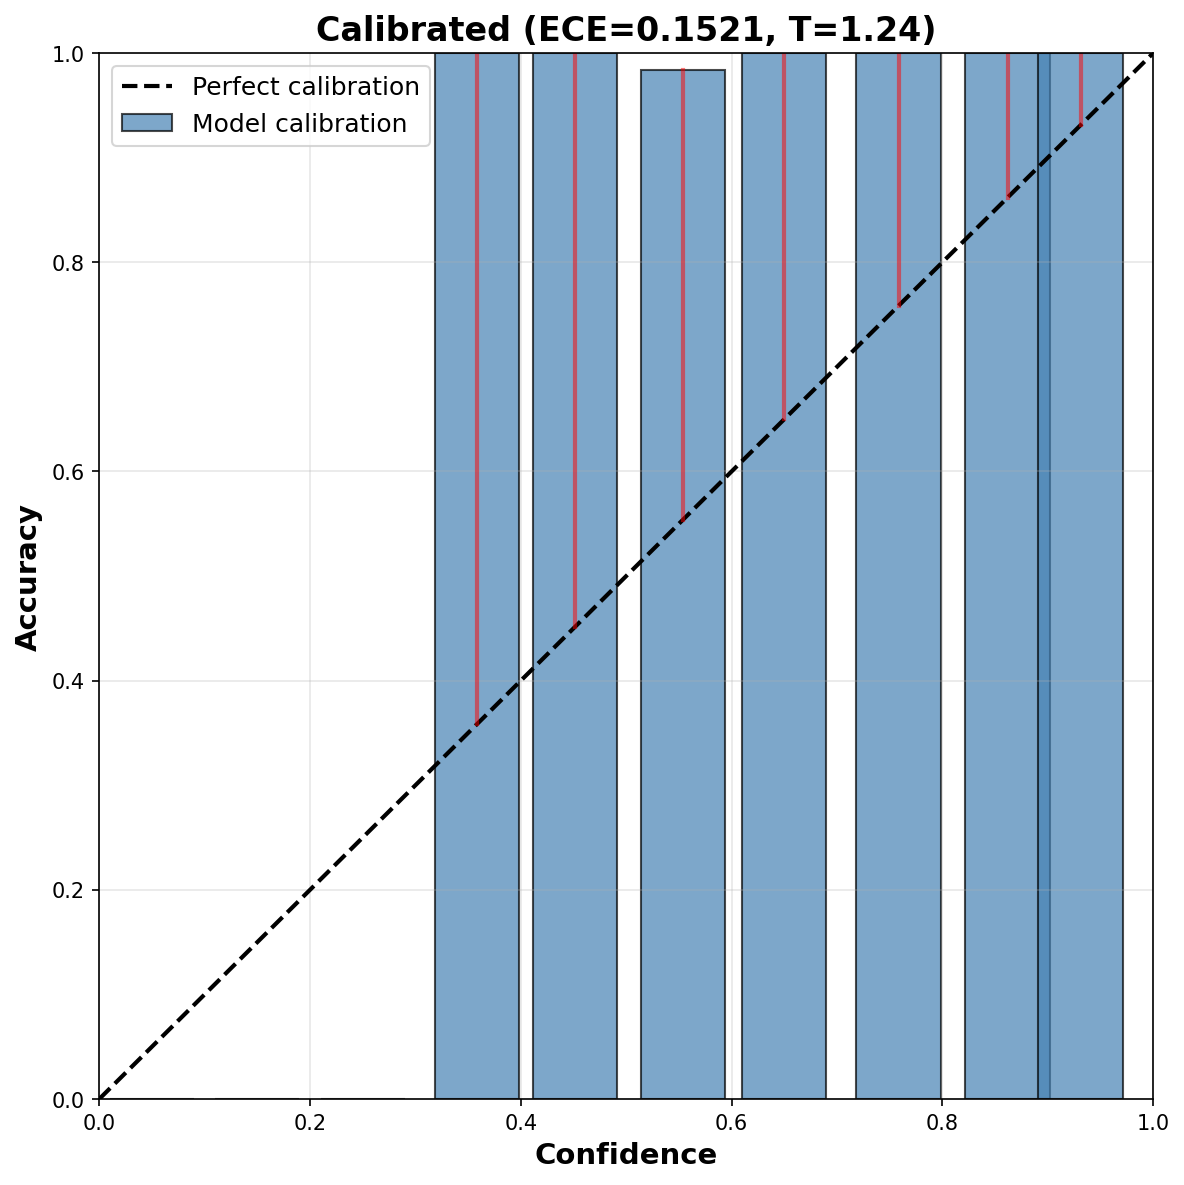

In [10]:
from IPython.display import Image, display
display(Image(f'{RESULTS_DIR}/plots/reliability_uncalibrated.png'))
display(Image(f'{RESULTS_DIR}/plots/reliability_calibrated.png'))

In [11]:
import shutil
from pathlib import Path

# Create zip files for models and results
print("Creating zip files...")

# Zip the models folder
shutil.make_archive('/kaggle/working/models_download', 'zip', '/kaggle/working/models')
print("✅ models.zip created")

# Zip the results folder
shutil.make_archive('/kaggle/working/results_download', 'zip', '/kaggle/working/results')
print("✅ results.zip created")

print("\n" + "="*60)
print("ZIP FILES READY FOR DOWNLOAD")
print("="*60)
print("1. models_download.zip - Contains calibration temperature file")
print("2. results_download.zip - Contains plots and metrics")
print("\nTo download:")
print("  - Click on the folder icon (left sidebar)")
print("  - Navigate to /kaggle/working/")
print("  - Right-click each .zip file → Download")

Creating zip files...
✅ models.zip created
✅ results.zip created

ZIP FILES READY FOR DOWNLOAD
1. models_download.zip - Contains calibration temperature file
2. results_download.zip - Contains plots and metrics

To download:
  - Click on the folder icon (left sidebar)
  - Navigate to /kaggle/working/
  - Right-click each .zip file → Download


In [12]:
import json
import pickle
from pathlib import Path

print("="*60)
print("PHASE 4 VERIFICATION")
print("="*60)

# 1. Check temperature file exists
temp_path = '/kaggle/working/models/calibration/temperature_augmented.pkl'
if Path(temp_path).exists():
    with open(temp_path, 'rb') as f:
        temp_data = pickle.load(f)
        temperature = temp_data['temperature']
    print(f"\n✅ Temperature file exists")
    print(f"   Temperature value: {temperature:.3f}")
    
    # Interpret temperature
    if 1.2 <= temperature <= 3.0:
        print(f"   Status: ✅ Normal range (model was overconfident)")
    else:
        print(f"   Status: ⚠️  Unusual value")
else:
    print("❌ Temperature file NOT found!")

# 2. Check metrics
metrics_path = '/kaggle/working/results/metrics/calibration_metrics.json'
if Path(metrics_path).exists():
    with open(metrics_path, 'r') as f:
        metrics = json.load(f)
    
    print(f"\n✅ Metrics file exists")
    print(f"\n📊 CALIBRATION RESULTS:")
    print(f"   Uncalibrated ECE:  {metrics['uncalibrated_ece']:.4f}")
    print(f"   Calibrated ECE:    {metrics['calibrated_ece']:.4f}")
    print(f"   Improvement:       {metrics['improvement']:.4f}")
    print(f"   Temperature:       {metrics['temperature']:.3f}")
    
    # Interpret ECE
    ece = metrics['calibrated_ece']
    print(f"\n📖 INTERPRETATION:")
    if ece < 0.05:
        print(f"   ✅ EXCELLENT calibration (ECE < 0.05)")
    elif ece < 0.10:
        print(f"   ✅ GOOD calibration (ECE < 0.10)")
    elif ece < 0.15:
        print(f"   ⚠️  FAIR calibration (ECE < 0.15)")
    else:
        print(f"   ❌ POOR calibration (ECE >= 0.15)")
    
    if metrics['improvement'] > 0:
        print(f"   ✅ Calibration improved ECE by {metrics['improvement']:.4f}")
    else:
        print(f"   ⚠️  Warning: Calibration didn't improve ECE")
else:
    print("❌ Metrics file NOT found!")

# 3. Check plots exist
plot1 = '/kaggle/working/results/plots/reliability_uncalibrated.png'
plot2 = '/kaggle/working/results/plots/reliability_calibrated.png'

if Path(plot1).exists() and Path(plot2).exists():
    print(f"\n✅ Both reliability plots exist")
else:
    print(f"\n❌ Plots missing!")

print("\n" + "="*60)
print("VERIFICATION COMPLETE")
print("="*60)

PHASE 4 VERIFICATION

✅ Temperature file exists
   Temperature value: 1.242
   Status: ✅ Normal range (model was overconfident)

✅ Metrics file exists

📊 CALIBRATION RESULTS:
   Uncalibrated ECE:  0.1821
   Calibrated ECE:    0.1521
   Improvement:       0.0300
   Temperature:       1.242

📖 INTERPRETATION:
   ❌ POOR calibration (ECE >= 0.15)
   ✅ Calibration improved ECE by 0.0300

✅ Both reliability plots exist

VERIFICATION COMPLETE


BEFORE vs AFTER CALIBRATION

BEFORE CALIBRATION (Uncalibrated)
If bars are ABOVE the diagonal line = Model is OVERCONFIDENT
(Says 90% confident but only 70% accurate)



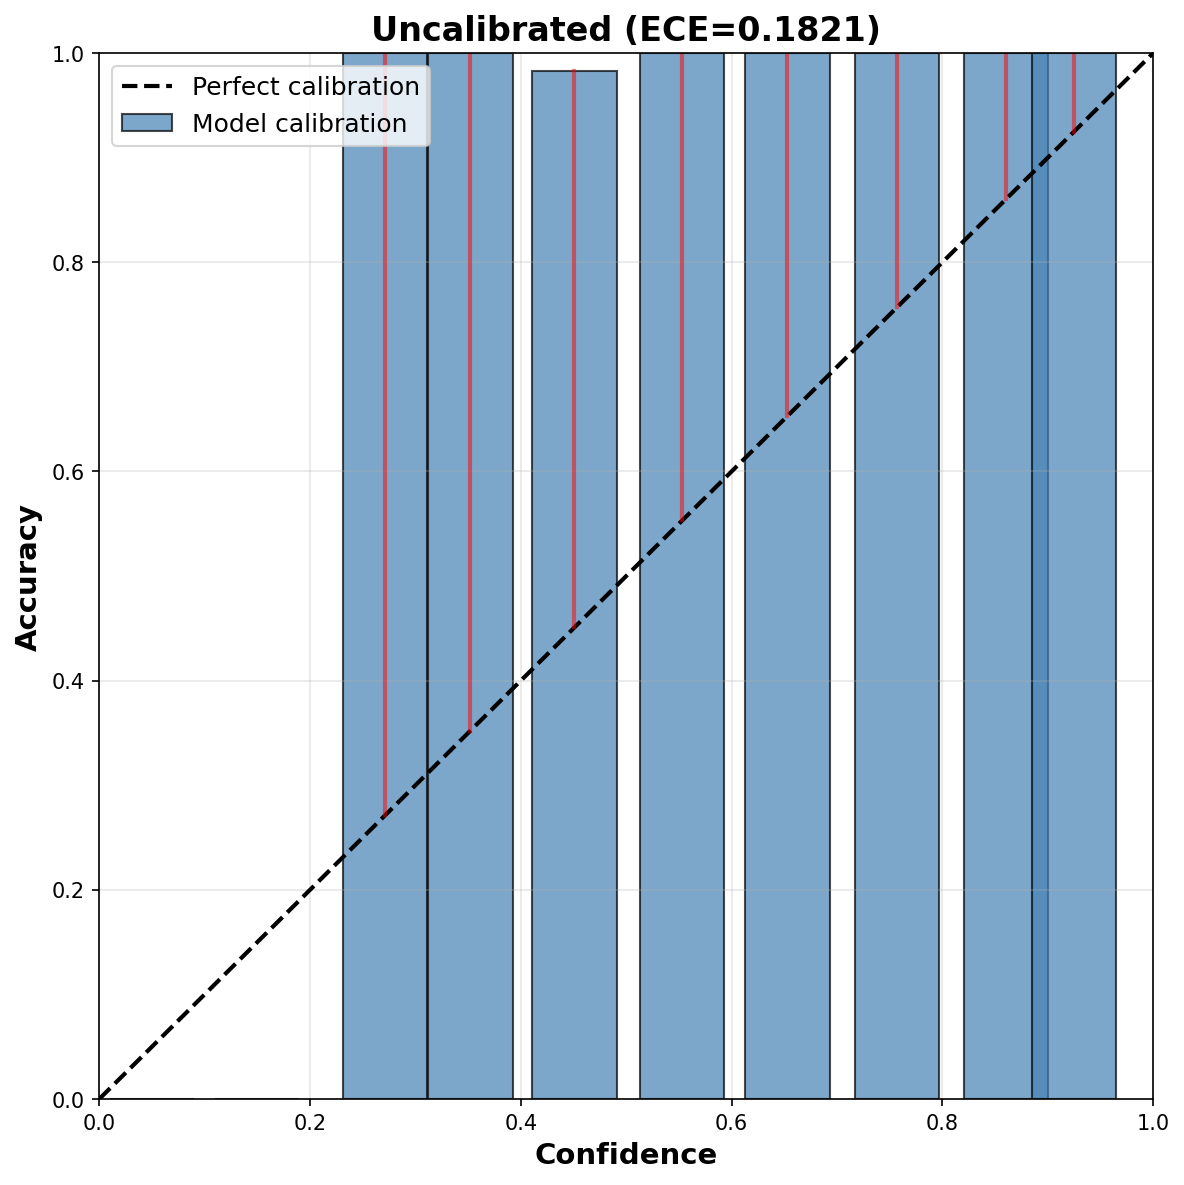


AFTER CALIBRATION (Calibrated)
Bars should be CLOSER to diagonal line = More honest confidence
(Says 90% confident and IS 90% accurate)



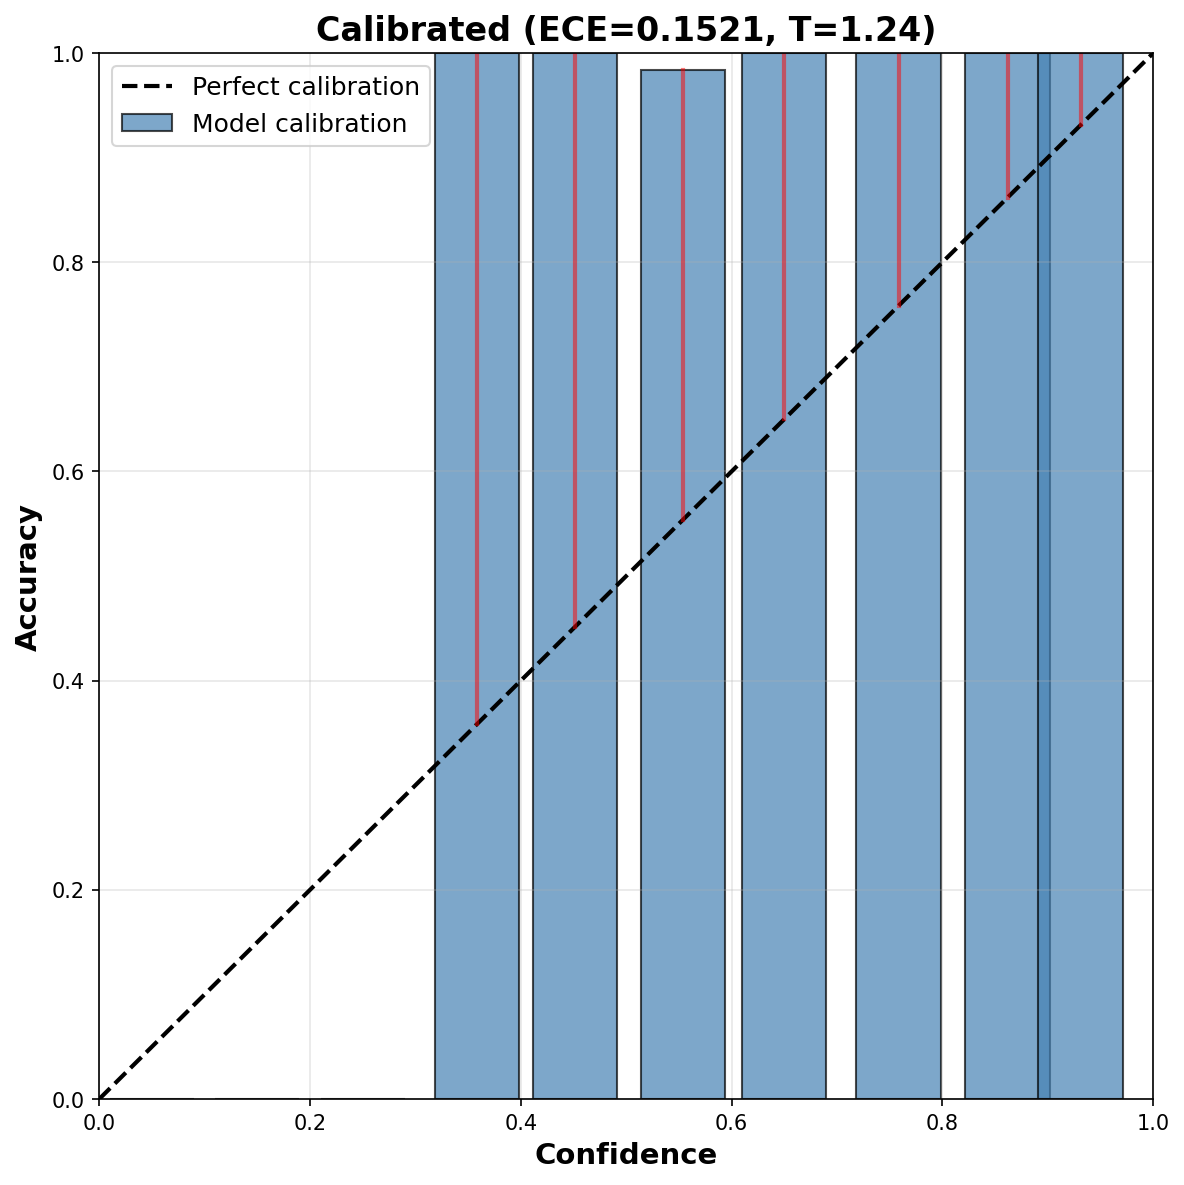

In [13]:
from IPython.display import Image, display
import matplotlib.pyplot as plt

print("BEFORE vs AFTER CALIBRATION\n")

print("="*60)
print("BEFORE CALIBRATION (Uncalibrated)")
print("="*60)
print("If bars are ABOVE the diagonal line = Model is OVERCONFIDENT")
print("(Says 90% confident but only 70% accurate)\n")
display(Image('/kaggle/working/results/plots/reliability_uncalibrated.png'))

print("\n" + "="*60)
print("AFTER CALIBRATION (Calibrated)")
print("="*60)
print("Bars should be CLOSER to diagonal line = More honest confidence")
print("(Says 90% confident and IS 90% accurate)\n")
display(Image('/kaggle/working/results/plots/reliability_calibrated.png'))

In [14]:
from ultralytics import YOLO
from pathlib import Path
import pickle

# Load model
model = YOLO('/kaggle/input/uav-landing/other/default/1/best.pt')

# Load temperature
with open('/kaggle/working/models/calibration/temperature_augmented.pkl', 'rb') as f:
    temperature = pickle.load(f)['temperature']

# Get a test image
test_images = list(Path('/kaggle/input/autonomous-drone-landing-dataset-teknofest/valid/valid/images').glob('*.jpg'))

# Test on first working image
for img_path in test_images[:20]:
    try:
        results = model(str(img_path), verbose=False)
        
        if results[0].boxes is not None and len(results[0].boxes) > 0:
            print("="*60)
            print(f"TEST IMAGE: {img_path.name}")
            print("="*60)
            print(f"Temperature: {temperature:.3f}\n")
            print(f"{'Detection':<12} {'Raw Conf':<12} {'Calibrated':<12} {'Change'}")
            print("-"*60)
            
            for i, box in enumerate(results[0].boxes[:5]):
                class_id = int(box.cls[0])
                raw_conf = float(box.conf[0])
                calibrated_conf = raw_conf ** (1.0 / temperature)
                change = raw_conf - calibrated_conf
                
                print(f"Class {class_id:<6} {raw_conf:>6.1%}      {calibrated_conf:>6.1%}      {change:+.3f}")
            
            print("\n💡 INTERPRETATION:")
            print("   - Raw Conf: Original model confidence (often too high)")
            print("   - Calibrated: Honest confidence (more trustworthy)")
            print("   - Positive change means model was overconfident")
            break
    except:
        continue


TEST IMAGE: frame_005428.jpg
Temperature: 1.242

Detection    Raw Conf     Calibrated   Change
------------------------------------------------------------
Class 2       93.9%       95.0%      -0.012
Class 3       74.1%       78.6%      -0.045
Class 3       60.5%       66.7%      -0.062

💡 INTERPRETATION:
   - Raw Conf: Original model confidence (often too high)
   - Calibrated: Honest confidence (more trustworthy)
   - Positive change means model was overconfident
